Bubba Gump, initially a local restaurant, became a sucessful company following the sucessful of the “Forest Gump” movie. However after an unexpected rapid growth in a few years, Bubba Gump Shrimp Company has been experiencing a slow growth in the following years and decreasing in sale over the last two years. Decrease in sale means the company is facing a danger of closure some of its units, or even bankrupt if the problem can not fix on time. Bubba Gump is now trying to figure out the way to understand the customer better to be able to boost the sale growth back. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pandas_profiling


In [2]:
data_url = "./DAT220_Final Project Data.xlsx"
data = pd.read_excel(data_url)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   first_name      500 non-null    object
 1   last_name       500 non-null    object
 2   city            500 non-null    object
 3   county          500 non-null    object
 4   state           500 non-null    object
 5   zip             500 non-null    int64 
 6   ZIP_2           500 non-null    int64 
 7   Restaurant      500 non-null    int64 
 8   RES_VISITS      500 non-null    int64 
 9   WEB_PURCH_YN    500 non-null    int64 
 10  Webstore_Spend  500 non-null    int64 
 11  WEB_VISITS      500 non-null    int64 
 12  THIRD_SPEND     500 non-null    int64 
 13  THIRD_VISITS    500 non-null    int64 
 14  Age             500 non-null    int64 
 15  Married_YN      500 non-null    object
 16  MARR_BIN        500 non-null    int64 
 17  Income          500 non-null    int64 
dtypes: int64(1

We got our first problem here. Wrong format for a few columns. We need to change it to a right type.

In [4]:
data = data.astype({'zip': 'object', 'ZIP_2': 'object', 'Restaurant': 'object', 'WEB_PURCH_YN': 'boolean', 'MARR_BIN': 'boolean'})

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_name      500 non-null    object 
 1   last_name       500 non-null    object 
 2   city            500 non-null    object 
 3   county          500 non-null    object 
 4   state           500 non-null    object 
 5   zip             500 non-null    object 
 6   ZIP_2           500 non-null    object 
 7   Restaurant      500 non-null    object 
 8   RES_VISITS      500 non-null    int64  
 9   WEB_PURCH_YN    500 non-null    boolean
 10  Webstore_Spend  500 non-null    int64  
 11  WEB_VISITS      500 non-null    int64  
 12  THIRD_SPEND     500 non-null    int64  
 13  THIRD_VISITS    500 non-null    int64  
 14  Age             500 non-null    int64  
 15  Married_YN      500 non-null    object 
 16  MARR_BIN        500 non-null    boolean
 17  Income          500 non-null    int

In [6]:
np.count_nonzero(data.Restaurant.unique())

51

In [7]:
np.count_nonzero(data.zip.unique())

451

In [8]:
data.describe()

,RES_VISITS,Webstore_Spend,WEB_VISITS,THIRD_SPEND,THIRD_VISITS,Age,Income
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,1.354000,40.474000,0.746000,20.226000,0.614000,42.49800,59.846000
std,0.630459,87.873163,0.794195,43.841431,0.738983,18.10651,20.799026
min,1.000000,0.000000,0.000000,0.000000,0.000000,19.00000,23.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,28.00000,44.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,38.00000,57.000000
75%,2.000000,32.000000,1.000000,19.000000,1.000000,57.00000,74.250000
max,3.000000,496.000000,3.000000,210.000000,3.000000,81.00000,116.000000


A few things here:
- Data is collected at 51 Restaurants and customers from 451 zipcodes. Unfortunately we don't have the restaurant zipcode/state to compare.
- Max restarant visits is 3, and max third visits is 3. We can assume that customers with RES_VISITS < 3 would have THIRD_VISITS and THIRD_SPEND = 0. If THIRD_VISITS > 1 then we assume that they came back 4 and 5 times (THIRD_VISITS = 3).
- At 50 percentile Webstore_Spend is 0 and 25 percentile WEB_VISITS is 0. This means the survey was conducted in restarant (RES_VISITS min = 1).

In [9]:
(data['RES_VISITS'][data['RES_VISITS'] == 3].count(), data['THIRD_VISITS'][data['THIRD_VISITS'] > 0].count(), data['THIRD_SPEND'][data['THIRD_SPEND'] > 0].count())

(42, 244, 126)

In [10]:
data['fullname'] = data['first_name'] + '' + data['last_name']
np.count_nonzero(data['fullname'].unique())

500

Total of 42 customers visit the restaurant three times (and up), but only 244 third visit and 126 third spend. Considering this is 500 different customers, there is probably something wrong in this data. Unfortunately we have no way to clarify this.

In [11]:
data.head()

,first_name,last_name,city,county,state,zip,ZIP_2,Restaurant,RES_VISITS,WEB_PURCH_YN,Webstore_Spend,WEB_VISITS,THIRD_SPEND,THIRD_VISITS,Age,Married_YN,MARR_BIN,Income,fullname
0,Lenna,Paprocki,Anchorage,Anchorage,AK,99501,99,155,2,True,191,3,63,1,28,N,False,42,LennaPaprocki
1,Roxane,Campain,Fairbanks,Fairbanks North Star,AK,99708,99,60,1,False,0,1,0,0,49,Y,True,112,RoxaneCampain
2,Erick,Ferencz,Fairbanks,Fairbanks North Star,AK,99712,99,155,2,False,0,0,0,0,44,Y,True,74,ErickFerencz
3,Penney,Weight,Anchorage,Anchorage,AK,99515,99,90,1,False,0,0,26,1,19,N,False,47,PenneyWeight
4,Wilda,Giguere,Anchorage,Anchorage,AK,99501,99,131,3,True,223,2,0,0,25,Y,True,55,WildaGiguere


In [12]:
data.zip.sort_values()

190     1581
192     1602
186     1602
195     1603
189     1742
       ...  
4      99501
0      99501
3      99515
1      99708
2      99712
Name: zip, Length: 500, dtype: object

Now the zipcode was in the wrong format so we need to fix it.

In [13]:
data.zip = data['zip'].apply(lambda x: str(x))

In [14]:
data.zip = data.zip.apply(lambda x: '0' + x if len(x) < 5 else x)

In [15]:
data.zip.sort_values().head(40)

190    01581
192    01602
186    01602
195    01603
189    01742
191    01887
185    02128
196    02138
187    02210
188    02346
194    02745
193    02760
421    02903
420    02904
423    02906
419    02909
422    02919
258    03865
214    04401
216    04401
215    04864
98     06473
96     06511
97     06515
100    06610
99     06854
294    07003
288    07004
278    07009
301    07011
304    07029
309    07032
295    07032
289    07039
269    07050
292    07055
273    07062
293    07071
302    07087
266    07104
Name: zip, dtype: object

Looks good now. Let's see if we have any missing data.

In [16]:
missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
missing.columns = (['count', '%'])
missing.sort_values('%')

,count,%
first_name,0,0.0
MARR_BIN,0,0.0
Married_YN,0,0.0
Age,0,0.0
THIRD_VISITS,0,0.0
THIRD_SPEND,0,0.0
WEB_VISITS,0,0.0
Webstore_Spend,0,0.0
Income,0,0.0
WEB_PURCH_YN,0,0.0


This is perfect! No missing data saves tons of time!

Let's drop some columns since they are not really necessary for the analysis.

In [17]:
cleaned_data = data.drop(columns=['Restaurant', 'ZIP_2', 'Married_YN', 'first_name', 'last_name', 'fullname'])

In [18]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            500 non-null    object 
 1   county          500 non-null    object 
 2   state           500 non-null    object 
 3   zip             500 non-null    object 
 4   RES_VISITS      500 non-null    int64  
 5   WEB_PURCH_YN    500 non-null    boolean
 6   Webstore_Spend  500 non-null    int64  
 7   WEB_VISITS      500 non-null    int64  
 8   THIRD_SPEND     500 non-null    int64  
 9   THIRD_VISITS    500 non-null    int64  
 10  Age             500 non-null    int64  
 11  MARR_BIN        500 non-null    boolean
 12  Income          500 non-null    int64  
dtypes: boolean(2), int64(7), object(4)
memory usage: 45.0+ KB


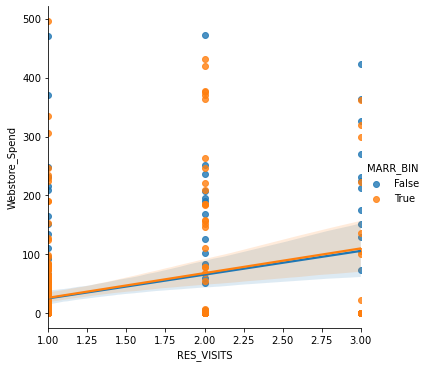

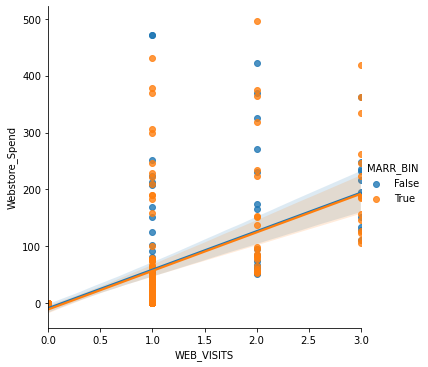

In [19]:
sns.lmplot(y='Webstore_Spend', x='RES_VISITS', data=cleaned_data, hue='MARR_BIN')
sns.lmplot(y='Webstore_Spend', x='WEB_VISITS', data=cleaned_data, hue='MARR_BIN');

From the plots, we can see that customers spend more on the webstore when they visit the restaurant and website more. There is no different between marriage and un-marriage customers.

Let's dig a little deeper in our customer's demographic.

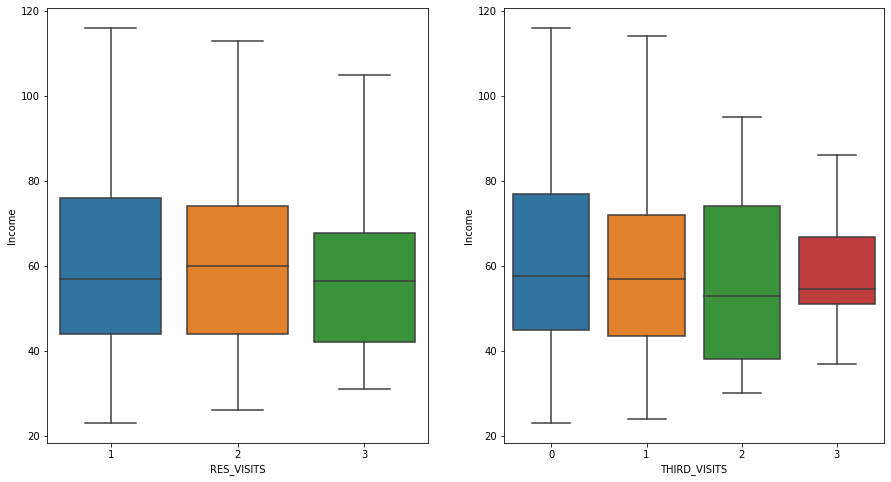

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.boxplot(x='RES_VISITS', y='Income', data=cleaned_data, ax=axs[0])
sns.boxplot(x='THIRD_VISITS', y='Income', data=cleaned_data, ax=axs[1]);

Average income seems to be the same for first time customers and previous customers. Looks like the one that keep coming back to us are the middle class with income around 45-75k/year. As Bubba Gump is a casual restaurant, it makes sense that the customers are not those making very high income (usually go to high end restarant) or too low income (might be attracted by fastfood restaurant/home cooking more).

What about the age of our customer?

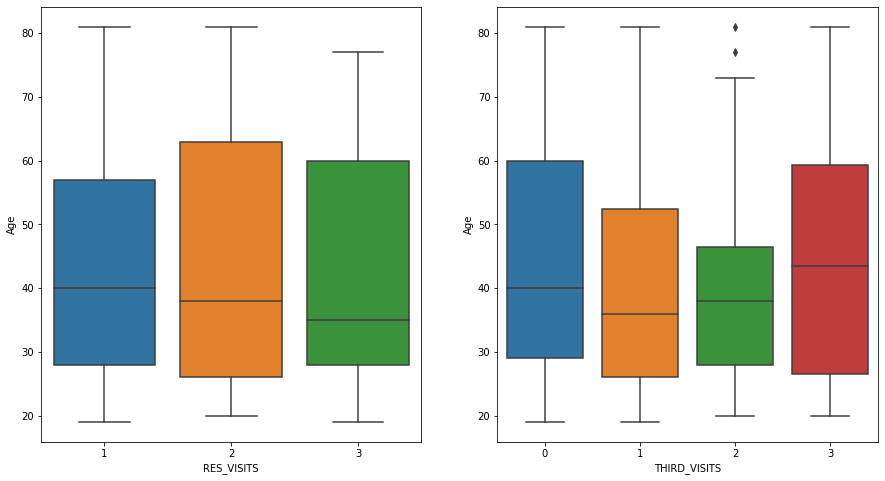

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.boxplot(x='RES_VISITS', y='Age', data=cleaned_data, ax=axs[0])
sns.boxplot(x='THIRD_VISITS', y='Age', data=cleaned_data, ax=axs[1]);

So our customers mainly are adults from 28-60 years old. Those are the age when people are working full-time and have energy/time/friend to go out. 

Marrial Status?

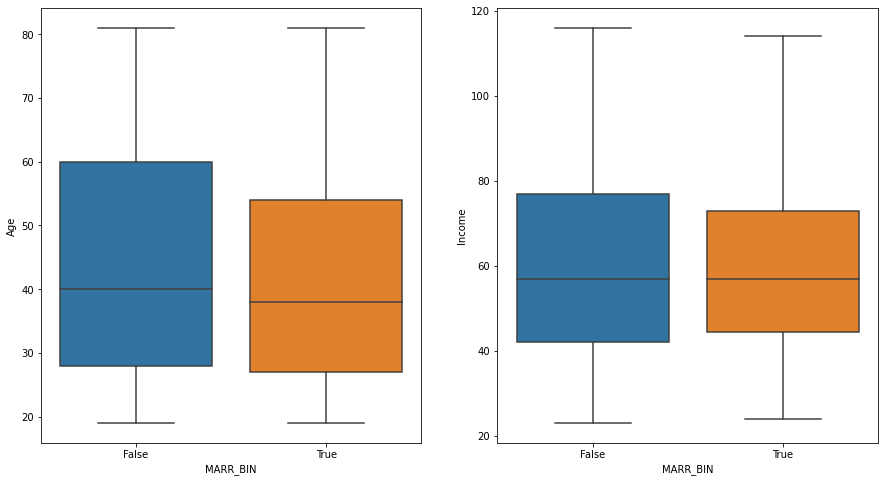

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.boxplot(x='MARR_BIN', y='Age', data=cleaned_data, ax=axs[0])
sns.boxplot(x='MARR_BIN', y='Income', data=cleaned_data, ax=axs[1]);

In [23]:
np.sum(cleaned_data.MARR_BIN == True)/len(cleaned_data.MARR_BIN)

0.606

Eventhough married customers make up 60% of the data, there is not really any different in age or income. Interesting thing here is there are more unmarried old adult come to the restaurants, would it be because without family, they have more time to hangout (and dine out)?

What about state?

In [24]:
cleaned_data_by_state = cleaned_data.groupby('state').agg(
                        Restaurant_visit = pd.NamedAgg(column='RES_VISITS', aggfunc='sum'),
                        Web_visit = pd.NamedAgg(column='WEB_VISITS', aggfunc='sum'),
                        Web_purchase = pd.NamedAgg(column='WEB_PURCH_YN', aggfunc='sum'),
                        Webstore_spend = pd.NamedAgg(column='Webstore_Spend', aggfunc='sum'),
                        Third_visit = pd.NamedAgg(column='THIRD_VISITS', aggfunc='sum'),
                        Third_visit_spend = pd.NamedAgg(column='THIRD_SPEND', aggfunc='sum'))
cleaned_data_by_state = cleaned_data_by_state.sort_values('Restaurant_visit', ascending=False).reset_index()
cleaned_data_by_state.head()

,state,Restaurant_visit,Web_visit,Web_purchase,Webstore_spend,Third_visit,Third_visit_spend
0,CA,89,51,31,3186,46,1424
1,NJ,82,52,24,4051,22,534
2,NY,59,35,21,3114,30,966
3,FL,46,21,9,1203,19,615
4,TX,40,20,12,727,24,780


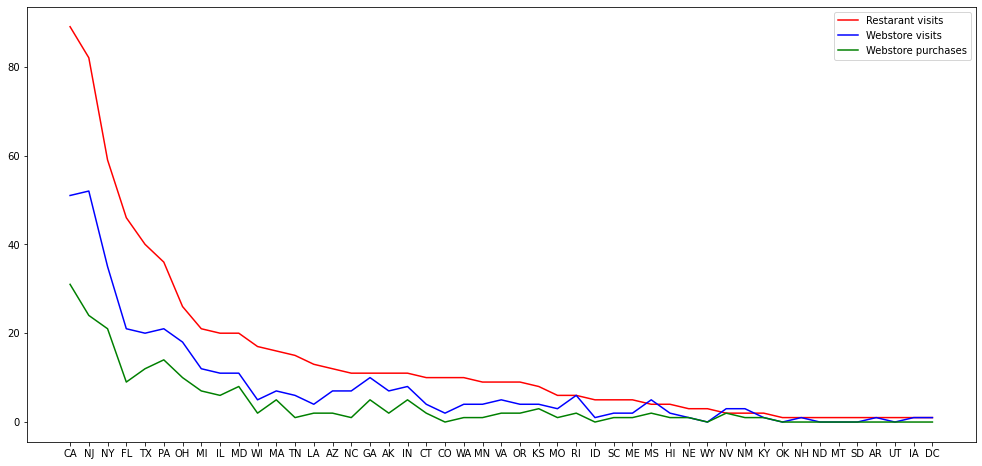

In [25]:
y1 = cleaned_data_by_state.Restaurant_visit
y2 = cleaned_data_by_state.Web_visit
y3 = list(cleaned_data_by_state.Web_purchase)
x = cleaned_data_by_state.state
plt.figure(figsize=(17, 8))
plt.plot(x, y1, 'r', label='Restarant visits')
plt.plot(x, y2, 'b', label='Webstore visits')
plt.plot(x, y3, 'g', label='Webstore purchases')
plt.legend();

Two things here:
- Restaurants in California, New Jersey, New York, Floria, Texas are leading the nation for number of visitings. Would it be because they have more restaurants in those states? Probably, since they are big state with more population, but we don't have data here to verify that.
- States with more restaurant visits are more likely to have more customers visit and make purchase on the webstore.

So if the customers come back, would they spend more money?

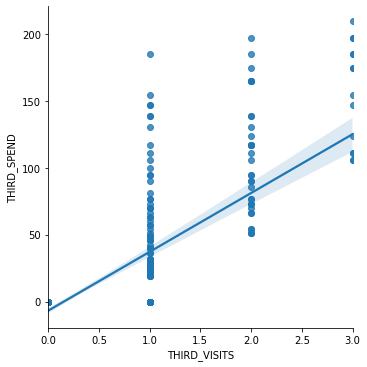

In [26]:
sns.lmplot(x='THIRD_VISITS', y='THIRD_SPEND', data=cleaned_data)

Great! It seems like if customers willing to comeback (which means they like us), they probably will spend more money in the restaurant too.

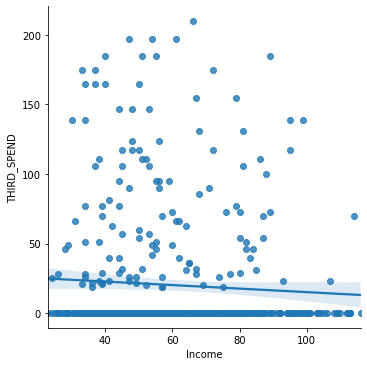

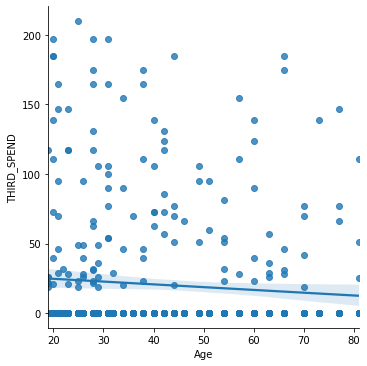

In [27]:
sns.lmplot(x='Income', y='THIRD_SPEND', data=cleaned_data)
sns.lmplot(x='Age', y='THIRD_SPEND', data=cleaned_data);

In [28]:
(np.count_nonzero(cleaned_data['THIRD_SPEND']), np.count_nonzero(cleaned_data['THIRD_VISITS']))

(126, 244)

244 third visits but only 126 third spend. Let's try to remove the zeros to see if we see something different

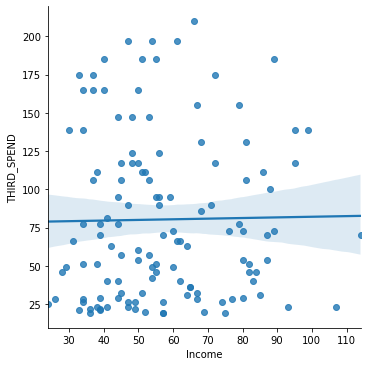

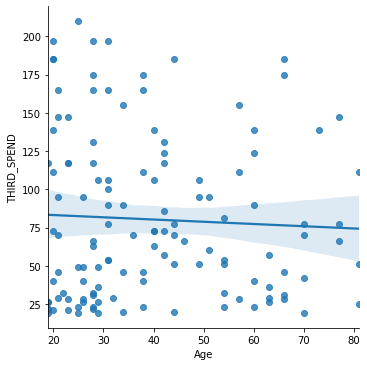

In [29]:
sns.lmplot(x='Income', y='THIRD_SPEND', data=cleaned_data[cleaned_data.THIRD_SPEND > 0])
sns.lmplot(x='Age', y='THIRD_SPEND', data=cleaned_data[cleaned_data.THIRD_SPEND > 0]);

No relation as we can see.

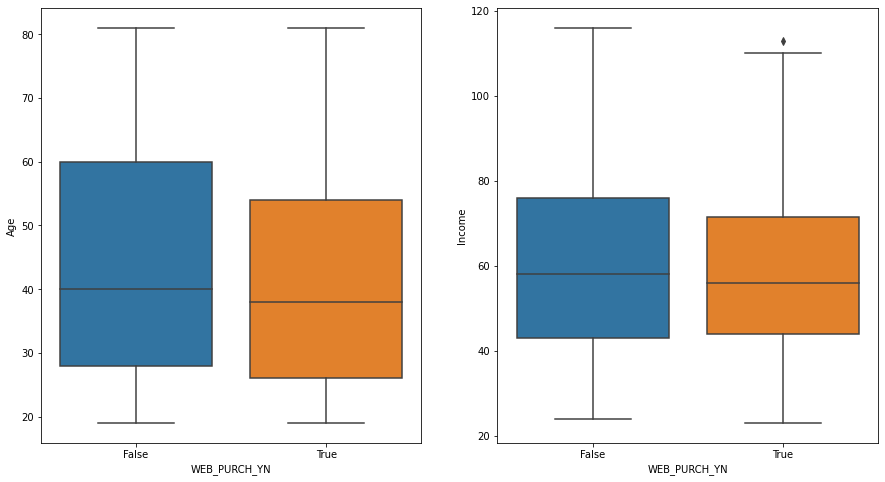

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.boxplot(x='WEB_PURCH_YN', y='Age', data=cleaned_data, ax=axs[0])
sns.boxplot(x='WEB_PURCH_YN', y='Income', data=cleaned_data, ax=axs[1]);

It looks like older people are less likely to purchase something on the webstore, while the income does not indicate anything noticable here. I want to do a test here to see if there is any real relation.

Now let's clean our data one last time and put everything to Machine Learning and see what we got.

In [31]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            500 non-null    object 
 1   county          500 non-null    object 
 2   state           500 non-null    object 
 3   zip             500 non-null    object 
 4   RES_VISITS      500 non-null    int64  
 5   WEB_PURCH_YN    500 non-null    boolean
 6   Webstore_Spend  500 non-null    int64  
 7   WEB_VISITS      500 non-null    int64  
 8   THIRD_SPEND     500 non-null    int64  
 9   THIRD_VISITS    500 non-null    int64  
 10  Age             500 non-null    int64  
 11  MARR_BIN        500 non-null    boolean
 12  Income          500 non-null    int64  
dtypes: boolean(2), int64(7), object(4)
memory usage: 45.0+ KB


In [32]:
columns=['city', 'county', 'state', 'zip']
cleaned_data.drop(columns=columns, inplace=True)
cleaned_data

,RES_VISITS,WEB_PURCH_YN,Webstore_Spend,WEB_VISITS,THIRD_SPEND,THIRD_VISITS,Age,MARR_BIN,Income
0,2,True,191,3,63,1,28,False,42
1,1,False,0,1,0,0,49,True,112
2,2,False,0,0,0,0,44,True,74
3,1,False,0,0,26,1,19,False,47
4,3,True,223,2,0,0,25,True,55
...,...,...,...,...,...,...,...,...,...
495,1,False,0,0,0,0,73,False,67
496,2,False,0,1,165,2,28,True,37
497,1,False,0,0,0,0,22,True,58
498,1,False,0,0,106,2,29,True,53


In [33]:
cleaned_data['WEB_PURCH_YN'] = cleaned_data['WEB_PURCH_YN'].astype(int)
cleaned_data['MARR_BIN'] = cleaned_data['MARR_BIN'].astype(int)

In [34]:
#cleaned_data['WEB_PURCH_YN_'] = cleaned_data['WEB_PURCH_YN'].replace({'True': 1, 'False': 0})

In [35]:
cleaned_data

,RES_VISITS,WEB_PURCH_YN,Webstore_Spend,WEB_VISITS,THIRD_SPEND,THIRD_VISITS,Age,MARR_BIN,Income
0,2,1,191,3,63,1,28,0,42
1,1,0,0,1,0,0,49,1,112
2,2,0,0,0,0,0,44,1,74
3,1,0,0,0,26,1,19,0,47
4,3,1,223,2,0,0,25,1,55
...,...,...,...,...,...,...,...,...,...
495,1,0,0,0,0,0,73,0,67
496,2,0,0,1,165,2,28,1,37
497,1,0,0,0,0,0,22,1,58
498,1,0,0,0,106,2,29,1,53


We will train the data to see what is the most important aspects that affect the Webstore_Spend and Third_Spend

In [36]:
dependent = ['Webstore_Spend', 'THIRD_SPEND']
X = cleaned_data.drop(columns=dependent)
y_web = cleaned_data['Webstore_Spend']
y_res = cleaned_data['THIRD_SPEND']

For Webstore_Spend

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y_web, test_size=0.3, random_state=123)

In [38]:
(X_train.shape, y_train.shape)

((350, 7), (350,))

In [39]:
(X_test.shape, y_test.shape)

((150, 7), (150,))

In [40]:
#Create function to get best score parameters
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [41]:
xgb_model_web = xgb.XGBRegressor(objective='reg:squarederror')

In [42]:
#Search for best params using RandomizedSearchCV
params = {
    "colsample_bytree": [i/10.0 for i in range(6, 10)],
    "gamma": [i/10.0 for i in range(0, 5)],
    "learning_rate": [i/10.0 for i in range(1, 11)], # default 0.1 
    "max_depth": range(1, 10), # default 3
    "subsample": [i/10.0 for i in range(6,10)],
    "min_child_weight": range(1, 6),
}

search = RandomizedSearchCV(xgb_model_web, param_distributions=params, random_state=42, n_iter=100, cv=5, verbose=1, n_jobs=-1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:    8.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.2s finished


Model with rank: 1
Mean validation score: 0.449 (std: 0.141)
Parameters: {'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 1, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 0.6}



In [43]:
xgb_model_web = xgb.XGBRegressor(objective='reg:squarederror', subsample=0.7, min_child_weight=3, max_depth=1, learning_rate=0.2, 
                                gamma=0, colsample_bytree=0.6, n_estimators=200)

In [44]:
xgb_model_web.fit(X_train, y_train, early_stopping_rounds=100, verbose=1, eval_set=[(X_test, y_test)])
y_web_pred = xgb_model_web.predict(X_test)

[0]	validation_0-rmse:75.87753
[1]	validation_0-rmse:73.35456
[2]	validation_0-rmse:66.19594
[3]	validation_0-rmse:61.83870
[4]	validation_0-rmse:58.84271
[5]	validation_0-rmse:57.47216
[6]	validation_0-rmse:55.82830
[7]	validation_0-rmse:55.03686
[8]	validation_0-rmse:53.64582
[9]	validation_0-rmse:52.98842
[10]	validation_0-rmse:53.02158
[11]	validation_0-rmse:52.74069
[12]	validation_0-rmse:52.85915
[13]	validation_0-rmse:52.50867
[14]	validation_0-rmse:52.56600
[15]	validation_0-rmse:52.38463
[16]	validation_0-rmse:52.61247
[17]	validation_0-rmse:52.79697
[18]	validation_0-rmse:53.01227
[19]	validation_0-rmse:53.16334
[20]	validation_0-rmse:53.35391
[21]	validation_0-rmse:53.09712
[22]	validation_0-rmse:53.28301
[23]	validation_0-rmse:53.24853
[24]	validation_0-rmse:53.35901
[25]	validation_0-rmse:53.61186
[26]	validation_0-rmse:53.63613
[27]	validation_0-rmse:53.45433
[28]	validation_0-rmse:53.55129
[29]	validation_0-rmse:53.68654
[30]	validation_0-rmse:53.59716
[31]	validation_0-

In [45]:
mean_absolute_error(y_test, y_web_pred)

28.498350658416747

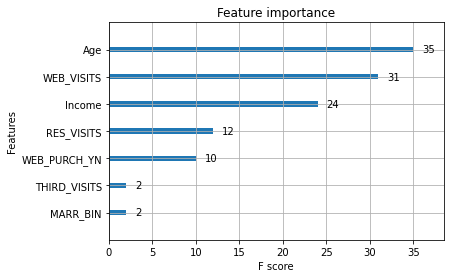

In [46]:
ax = xgb.plot_importance(xgb_model_web)
#fig = ax.figure
#fig.set_size_inches(10, 20)

Interestingly, Age is the most important aspect that affects the Webstore_Spend.

Now let's see for THIRD_SPEND

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y_res, test_size=0.3, random_state=123)

In [48]:
xgb_model_res = xgb.XGBRegressor(objective='reg:squarederror')

In [49]:
#Search for best params using RandomizedSearchCV
params = {
    "colsample_bytree": [i/10.0 for i in range(6, 10)],
    "gamma": [i/10.0 for i in range(0, 5)],
    "learning_rate": [i/10.0 for i in range(1, 11)], # default 0.1 
    "max_depth": range(1, 10), # default 3
    "subsample": [i/10.0 for i in range(6,10)],
    "min_child_weight": range(1, 6),
}

search = RandomizedSearchCV(xgb_model_res, param_distributions=params, random_state=42, n_iter=100, cv=5, verbose=1, n_jobs=-1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.8s


Model with rank: 1
Mean validation score: 0.562 (std: 0.087)
Parameters: {'subsample': 0.9, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.6s finished


In [50]:
xgb_model_res = xgb.XGBRegressor(objective='reg:squarederror', subsample=0.9, min_child_weight=5, max_depth=1, learning_rate=0.2, 
                                gamma=0.3, colsample_bytree=0.8, n_estimators=200)

In [51]:
xgb_model_res.fit(X_train, y_train, early_stopping_rounds=100, verbose=1, eval_set=[(X_test, y_test)])
y_res_pred = xgb_model_res.predict(X_test)

[0]	validation_0-rmse:39.09885
[1]	validation_0-rmse:34.36606
[2]	validation_0-rmse:30.92385
[3]	validation_0-rmse:28.12925
[4]	validation_0-rmse:26.54141
[5]	validation_0-rmse:26.29184
[6]	validation_0-rmse:26.20878
[7]	validation_0-rmse:25.25101
[8]	validation_0-rmse:24.00452
[9]	validation_0-rmse:24.01784
[10]	validation_0-rmse:23.97843
[11]	validation_0-rmse:22.88348
[12]	validation_0-rmse:21.58582
[13]	validation_0-rmse:21.09182
[14]	validation_0-rmse:20.53566
[15]	validation_0-rmse:20.56143
[16]	validation_0-rmse:19.79767
[17]	validation_0-rmse:19.90516
[18]	validation_0-rmse:19.70318
[19]	validation_0-rmse:19.64279
[20]	validation_0-rmse:19.11836
[21]	validation_0-rmse:18.74381
[22]	validation_0-rmse:18.65956
[23]	validation_0-rmse:18.62608
[24]	validation_0-rmse:18.42931
[25]	validation_0-rmse:18.34964
[26]	validation_0-rmse:18.45990
[27]	validation_0-rmse:18.39803
[28]	validation_0-rmse:18.29654
[29]	validation_0-rmse:18.30345
[30]	validation_0-rmse:18.30910
[31]	validation_0-

In [52]:
mean_absolute_error(y_test, y_res_pred)

11.832521583686272

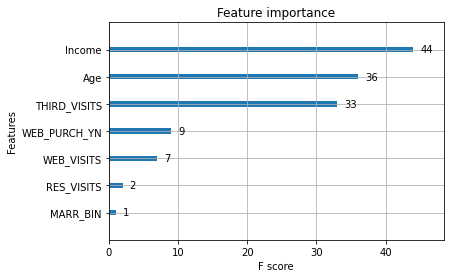

In [53]:
ax = xgb.plot_importance(xgb_model_res)

Now Income and Age are the most important that drives the third_spend up/down

In [54]:
cleaned_data.corr()

,RES_VISITS,WEB_PURCH_YN,Webstore_Spend,WEB_VISITS,THIRD_SPEND,THIRD_VISITS,Age,MARR_BIN,Income
RES_VISITS,1.000000,0.054807,0.294344,0.183940,-0.080116,-0.084643,0.004539,-0.079686,-0.030679
WEB_PURCH_YN,0.054807,1.000000,0.586431,0.687501,0.041807,0.015200,-0.039851,0.010564,-0.033596
Webstore_Spend,0.294344,0.586431,1.000000,0.611933,-0.005871,-0.003411,-0.036754,-0.014763,-0.029950
WEB_VISITS,0.183940,0.687501,0.611933,1.000000,-0.040882,-0.010319,-0.003728,-0.005355,0.030141
THIRD_SPEND,-0.080116,0.041807,-0.005871,-0.040882,1.000000,0.742184,-0.082687,-0.012941,-0.060131
THIRD_VISITS,-0.084643,0.015200,-0.003411,-0.010319,0.742184,1.000000,-0.076816,-0.027954,-0.063591
Age,0.004539,-0.039851,-0.036754,-0.003728,-0.082687,-0.076816,1.000000,-0.056998,0.109281
MARR_BIN,-0.079686,0.010564,-0.014763,-0.005355,-0.012941,-0.027954,-0.056998,1.000000,-0.027842
Income,-0.030679,-0.033596,-0.029950,0.030141,-0.060131,-0.063591,0.109281,-0.027842,1.000000


Based on 2 models and the correlation, we can conclude a few things:
- Customer's age and income are the most important things that drives the money flow both on webstore and in restaurant.
- Based on the correlation, the older and more income, the less money they spend. Therefore the company probably should target younger and middle-class customers.
- Marital status does not affect customer's choice.